## OSM与本地的建筑数据对比

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 读取数据
# gdf_factories = gpd.read_file("path/to/your_processing_points.shp").to_crs(epsg=32632)
gdf_buildings = gpd.read_file("origin_data/5. Buildings").to_crs(epsg=32632)
gdf_buildings_osm = gpd.read_file("origin_data/5. Buildings_OSM").to_crs(epsg=32632)

# 统一字段名用于对比（可选）
gdf_buildings['source'] = 'custom'
gdf_buildings_osm['source'] = 'osm'

# 合并两个数据源（用于对比绘图）
gdf_compare = gpd.GeoDataFrame(pd.concat([gdf_buildings, gdf_buildings_osm], ignore_index=True), crs=gdf_buildings.crs)

# 面积统计（单位：平方米）
area_custom = gdf_buildings.geometry.area.sum()
area_osm = gdf_buildings_osm.geometry.area.sum()

# 数量统计
count_custom = len(gdf_buildings)
count_osm = len(gdf_buildings_osm)

print("🏗️ 自有建筑数据：")
print(f"建筑数量: {count_custom}")
print(f"总建筑面积: {area_custom / 10000:.2f} 公顷")

print("\n🗺️ OSM 建筑数据：")
print(f"建筑数量: {count_osm}")
print(f"总建筑面积: {area_osm / 10000:.2f} 公顷")

🏗️ 自有建筑数据：
建筑数量: 189600
总建筑面积: 4245.02 公顷

🗺️ OSM 建筑数据：
建筑数量: 149836
总建筑面积: 3236.25 公顷


# 渲染图像

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box,Polygon,Point
import os

def square_buffer(center_point, half_size=500):
    x, y = center_point.x, center_point.y
    return box(x - half_size, y - half_size, x + half_size, y + half_size)

building = gpd.read_file("processing_data/building_black").to_crs(epsg=32632)
farming = gpd.read_file("processing_data/farming_green").to_crs(epsg=32632)
processing = gpd.read_file("processing_data/processing_red").to_crs(epsg=32632)
road = gpd.read_file("processing_data/road_grey").to_crs(epsg=32632)
water = gpd.read_file("processing_data/water_blue").to_crs(epsg=32632)

processing_center = processing.unary_union.centroid

output_dir = "rendered_images"
os.makedirs(output_dir, exist_ok=True)


# 4. 渲染函数：以一个点为中心，裁剪5km范围并渲染图像
def render_one_image(center_point, index):
    buffer = square_buffer(center_point, half_size=500)  # 250m 半径 = 500m 宽正方形

    def clip_layer(gdf): return gdf[gdf.geometry.intersects(buffer)]

    bld_clip = clip_layer(building)
    farm_clip = clip_layer(farming)
    proc_clip = clip_layer(processing)
    road_clip = clip_layer(road)
    water_clip = clip_layer(water)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_facecolor("white")

    # 顺序渲染
    water_clip.plot(ax=ax, color='blue', edgecolor='none')
    farm_clip.plot(ax=ax, color='green', edgecolor='none')
    road_clip.plot(ax=ax, color='grey', linewidth=5)
    bld_clip.plot(ax=ax, color='black', edgecolor='none')
    proc_clip.plot(ax=ax, color='red')

    ax.set_xlim(buffer.bounds[0], buffer.bounds[2])
    ax.set_ylim(buffer.bounds[1], buffer.bounds[3])
    ax.axis("off")

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"render_{index:03d}.png")
    plt.savefig(save_path, dpi=300)
    plt.close()

    # 5. 遍历 processing 图层的每个 geometry（通常是 Polygon 或 Point）
for idx, row in processing.iterrows():
    center = row.geometry.centroid
    render_one_image(center, idx)

print(f"✅ 共生成 {len(processing)} 张图，保存在 {output_dir}/ 中")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [5]:
from PIL import Image
import numpy as np
import os

image_folder = "rendered_images"
img_list = []

for i in range(103):
    img = Image.open(os.path.join(image_folder, f"render_{i:03d}.png")).resize((224, 224)).convert("RGB")
    img_array = np.array(img) / 255.0
    img_list.append(img_array)

img_array_all = np.stack(img_list)  # shape: (103, 224, 224, 3)

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

# 使用预训练的 ResNet18
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # 去掉分类头，保留特征输出
model.eval()

# 转换图像为 tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

features = []

with torch.no_grad():
    for img in img_list:
        x = transform(Image.fromarray((img * 255).astype(np.uint8)))
        x = x.unsqueeze(0)  # batch 维度
        feat = model(x).squeeze().numpy()
        features.append(feat)

X = np.stack(features)  # shape: (103, 512)


D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Elena/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [02:48<00:00, 279kB/s] 


D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


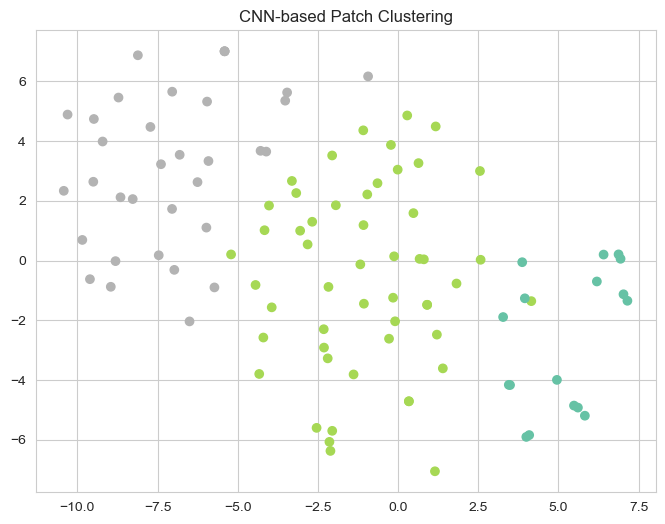

In [10]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n_clusters = 3  # 你可以试着调成 3～6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)


X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='Set2')
plt.title("CNN-based Patch Clustering")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'renderimage4/patch_25.png'

<Figure size 1200x800 with 0 Axes>